Loading the dataset index
Total entries in index: 1300
Entries with complete data: 890
Total entries after cleaning: 890
Number of unique songs: 732
Number of unique artists: 420

Songs per decade:
decade
1950     27
1960    252
1970    316
1980    252
1990     43
Name: count, dtype: int64


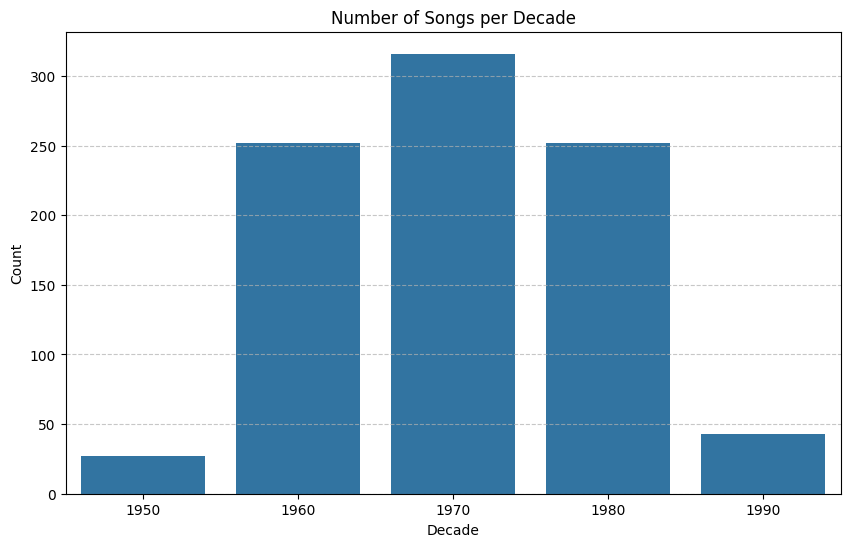


Number of songs with chroma features: 890
Number of songs with lab files: 890
Number of songs with both features and labels: 890

Exploring example song ID: 0326
Chroma shape for song 0326: (4314, 26)
Tuning shape for song 0326: (1, 5)

Sample of chroma data:
               0        1        2         3         4         5         6   \
0  /tmp/audio.wav  0.00000  0.00000  0.000000  0.000000  0.000000  0.000000   
1             NaN  0.04644  0.00000  0.000000  0.000000  0.000000  0.000000   
2             NaN  0.09288  1.40757  0.702197  0.545443  0.526746  0.949887   
3             NaN  0.13932  1.62605  0.857465  0.429106  0.772889  0.783598   
4             NaN  0.18576  2.05422  0.891278  0.121738  0.000000  0.369681   

         7         8         9   ...       16        17        18        19  \
0  0.000000  0.000000  0.000000  ...  0.00000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  ...  0.00000  0.000000  0.000000  0.000000   
2  1.033950  0.160175  0.00

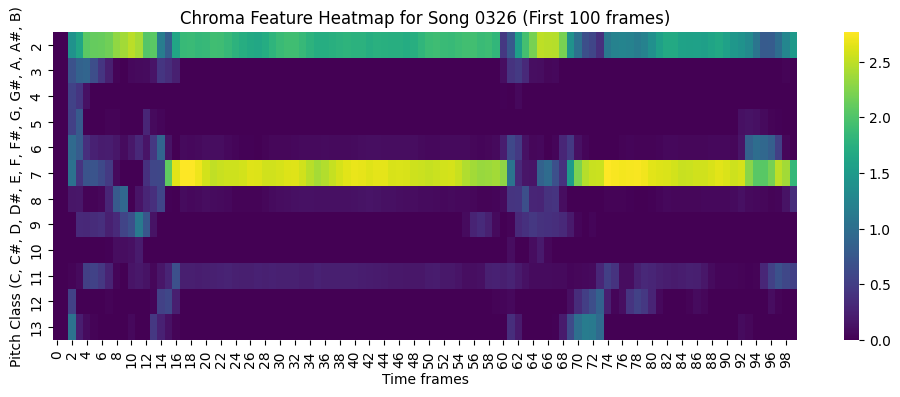


Number of chord segments for song 0326: 92

Sample of chord labels:
   start_time  end_time  chord
0    0.000000  0.278639      N
1    0.278639  0.618360      N
2    0.618360  2.996402  D:maj
3    2.996402  3.336122  D:maj
4    3.336122  5.973475  D:maj

Number of unique chords in song 0326: 14

Most common chords in this song:
chord
B:min          19
F#:7           10
D:maj           9
E:min7          8
F#:sus4(b7)     8
F#:min          6
G#:hdim7        5
D:maj7          5
C#:7            5
A:7             5
Name: count, dtype: int64


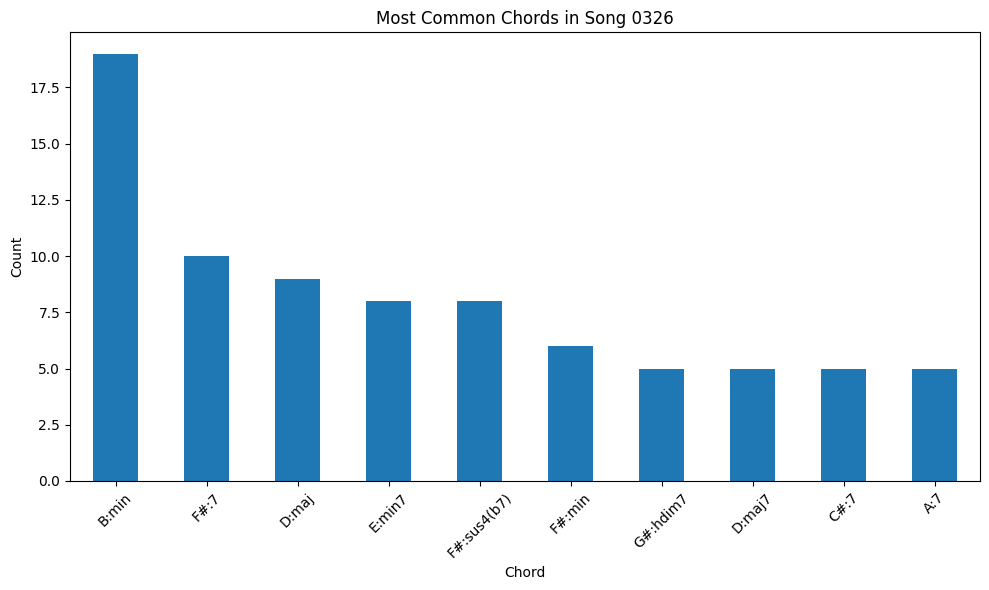

Analyzing chords: 100%|██████████| 100/100 [00:00<00:00, 226.34it/s]



Analyzed chord distribution across 100 songs
Total unique chords: 386
Total chord instances: 13461


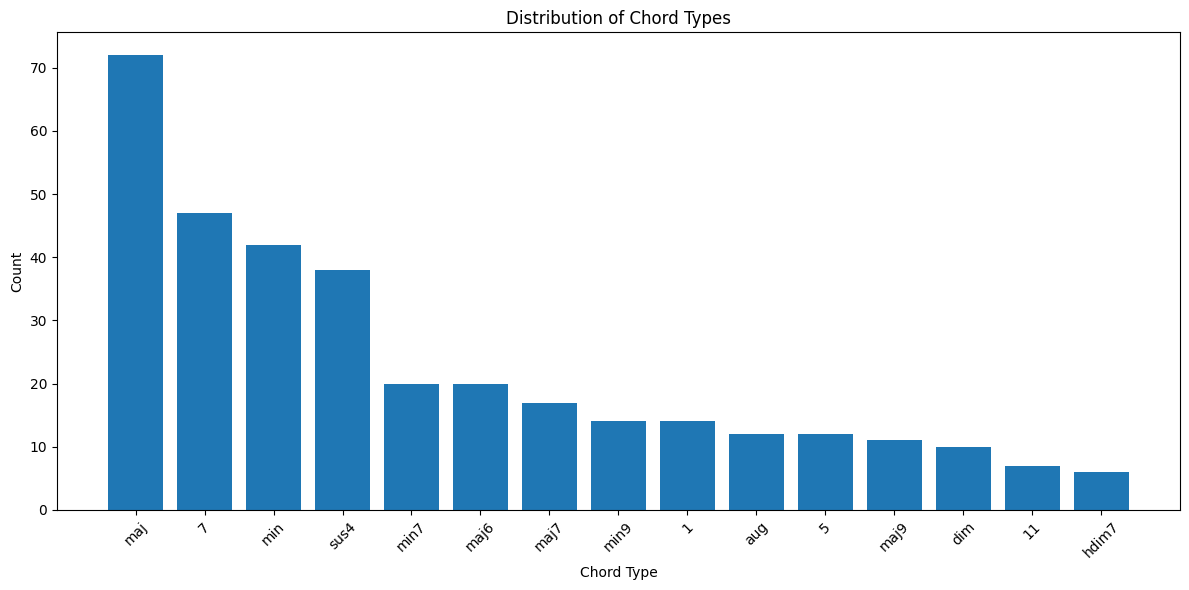

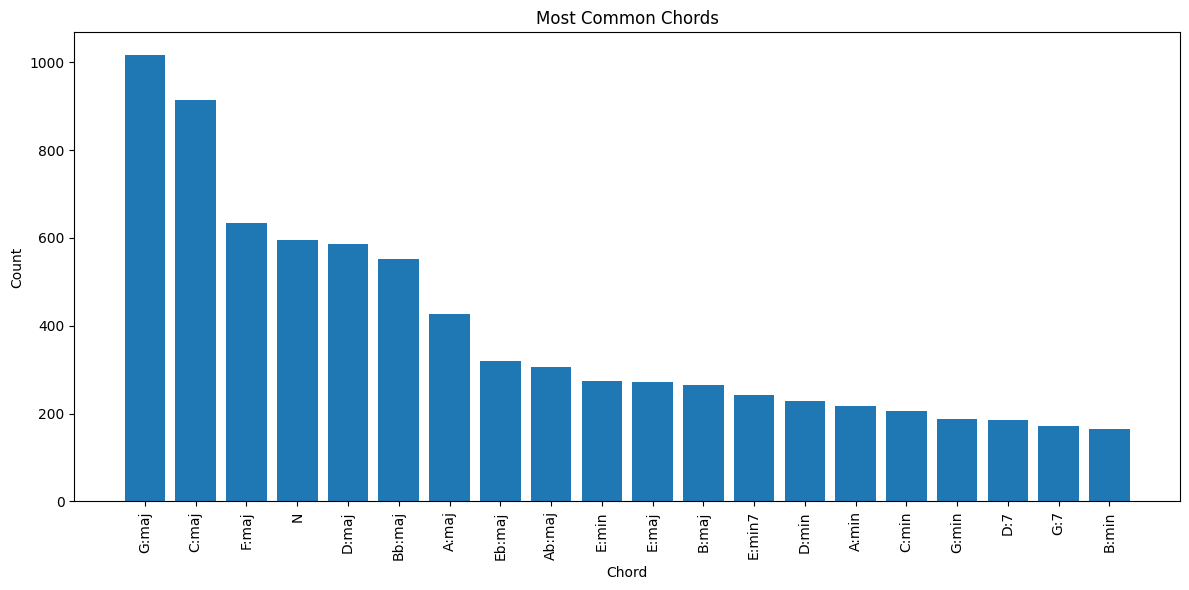

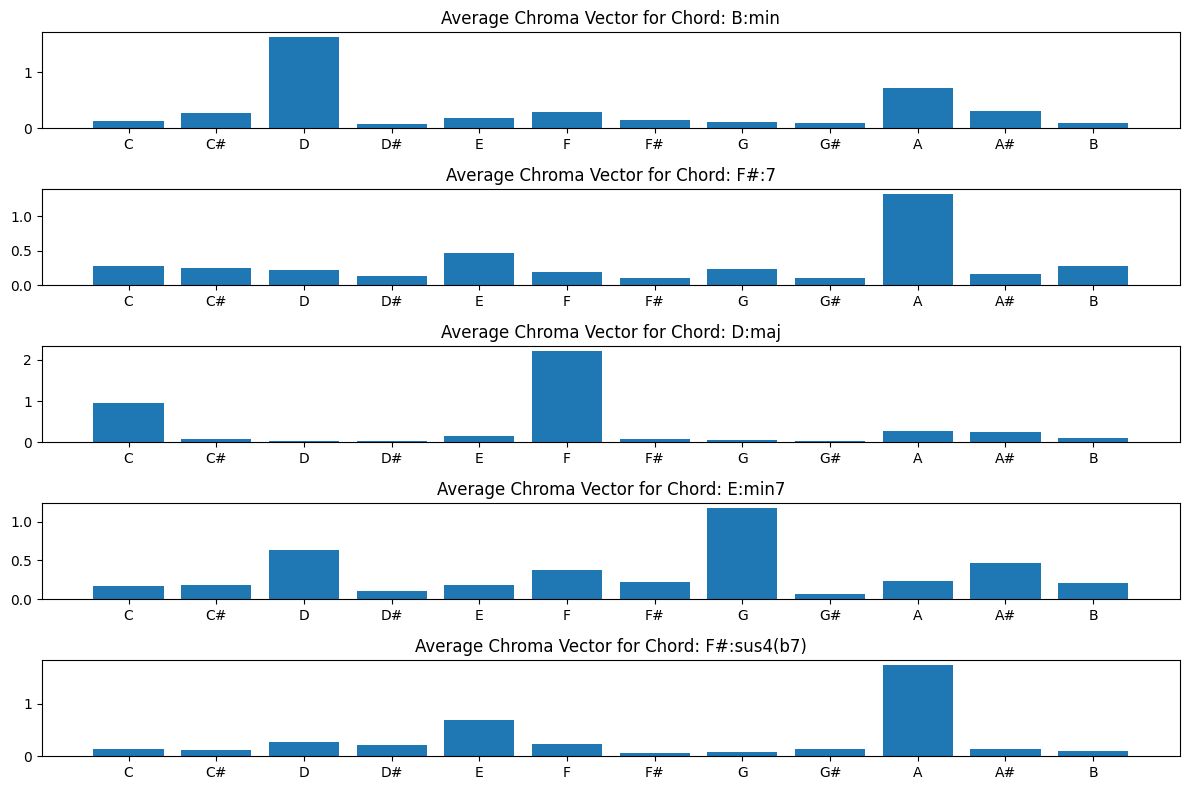

Analyzing chord simplification: 100%|██████████| 100/100 [00:00<00:00, 969.95it/s]



Original unique chord classes: 386
Simplified unique chord classes: 79
Reduction: 307 classes (79.53%)


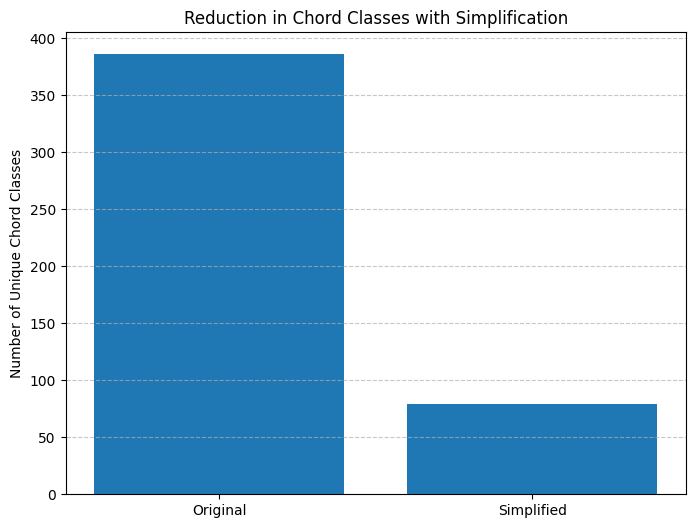


=== EDA Summary ===
• Dataset contains 890 songs spanning from the 1950s to 1990s
• The dataset has 386 unique chord classes
• Simplifying chords reduces the number of classes from 386 to 79
• Chroma features provide a 12-dimensional vector representing pitch class intensities
• Each song has an average of 134.6 chord segments
• The dataset provides a rich source for training chord recognition models
• Memory efficiency will be critical given the large number of chord classes and data points


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from collections import Counter
import re
from tqdm import tqdm
import random

# Set the paths
data_dir = Path('data/McGill-Billboard')
chordino_dir = data_dir / 'chordino'
lab_dir = data_dir / 'lab'
annotations_dir = data_dir / 'annotations'
index_path = data_dir / 'index.csv'

# 1. Dataset Overview
print("Loading the dataset index")
index_df = pd.read_csv(index_path)
print(f"Total entries in index: {len(index_df)}")
print(f"Entries with complete data: {index_df['title'].notna().sum()}")

# Drop entries with missing data
index_df = index_df.dropna(subset=['title'])
print(f'Total entries after cleaning: {len(index_df)}')

# Display basic information
print(f"Number of unique songs: {index_df['title'].nunique()}")
print(f"Number of unique artists: {index_df['artist'].nunique()}")

# Convert chart_date to datetime
index_df['chart_date'] = pd.to_datetime(index_df['chart_date'])

# Extract year and decade
index_df['year'] = index_df['chart_date'].dt.year
index_df['decade'] = (index_df['year'] // 10) * 10

# Analyze the decade distribution
decade_counts = index_df['decade'].value_counts().sort_index()
print("\nSongs per decade:")
print(decade_counts)

# Visualize the distribution of songs per decade
plt.figure(figsize=(10, 6))
sns.barplot(x=decade_counts.index, y=decade_counts.values)
plt.title('Number of Songs per Decade')
plt.xlabel('Decade')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('songs_per_decade.png')
plt.show()

# 2. Checking Data Availability
song_ids = [d.name for d in chordino_dir.iterdir() if d.is_dir()]
print(f"\nNumber of songs with chroma features: {len(song_ids)}")

# Check if the same songs have lab files
lab_ids = [d.name for d in lab_dir.iterdir() if d.is_dir()]
print(f"Number of songs with lab files: {len(lab_ids)}")

# Find songs that have both chroma and labels
common_ids = set(song_ids).intersection(set(lab_ids))
print(f"Number of songs with both features and labels: {len(common_ids)}")

# 3. Explore Chroma Features
example_id = list(common_ids)[random.randint(0, len(common_ids)-1)]
print(f"\nExploring example song ID: {example_id}")

# Load chroma features for the example song
chroma_path = chordino_dir / example_id / 'bothchroma.csv'
tuning_path = chordino_dir / example_id / 'tuning.csv'

if chroma_path.exists() and tuning_path.exists():
    chroma_data = pd.read_csv(chroma_path, header=None)
    tuning_data = pd.read_csv(tuning_path, header=None)
    
    print(f"Chroma shape for song {example_id}: {chroma_data.shape}")
    print(f"Tuning shape for song {example_id}: {tuning_data.shape}")
    
    # Display a sample of the chroma data
    print("\nSample of chroma data:")
    print(chroma_data.head())
    
    # Plot chroma data as a heatmap
    plt.figure(figsize=(12, 4))
    # Skip the first column (metadata) and use only pitch data
    try:
        # Try to get chroma columns (usually columns 2-13)
        chroma_plot_data = chroma_data.iloc[:100, 2:14].astype(float)  # First 100 rows for visibility
        sns.heatmap(chroma_plot_data.T, cmap='viridis', cbar=True)
        plt.title(f'Chroma Feature Heatmap for Song {example_id} (First 100 frames)')
        plt.xlabel('Time frames')
        plt.ylabel('Pitch Class (C, C#, D, D#, E, F, F#, G, G#, A, A#, B)')
        plt.savefig('chroma_heatmap.png')
        plt.show()
    except Exception as e:
        print(f"Error creating heatmap: {e}")
else:
    print(f"Chroma or tuning data not found for song {example_id}")

# 4. Explore Chord Labels
lab_path = lab_dir / example_id / "full.lab"

if lab_path.exists():
    # Read the lab file (tab-separated with no header)
    lab_data = pd.read_csv(lab_path, sep='\t', header=None, names=['start_time', 'end_time', 'chord'])
    
    print(f"\nNumber of chord segments for song {example_id}: {len(lab_data)}")
    print("\nSample of chord labels:")
    print(lab_data.head())
    
    # Count the unique chords in this song
    print(f"\nNumber of unique chords in song {example_id}: {lab_data['chord'].nunique()}")
    
    # Most common chords in this song
    most_common_chords = lab_data['chord'].value_counts().head(10)
    print("\nMost common chords in this song:")
    print(most_common_chords)
    
    # Plot the distribution of chord types
    plt.figure(figsize=(10, 6))
    most_common_chords.plot(kind='bar')
    plt.title(f'Most Common Chords in Song {example_id}')
    plt.xlabel('Chord')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('common_chords.png')
    plt.show()
else:
    print(f"Lab file not found for song {example_id}")

# 5. Analyze Chord Classes Across the Dataset
def analyze_chord_distribution(song_ids, max_songs=100):
    """Analyze the distribution of chord classes across multiple songs"""
    all_chords = []
    processed_songs = 0
    
    for song_id in tqdm(song_ids, desc="Analyzing chords"):
        if processed_songs >= max_songs:
            break
            
        lab_path = lab_dir / song_id / "full.lab"
        if lab_path.exists():
            lab_data = pd.read_csv(lab_path, sep='\t', header=None, names=['start_time', 'end_time', 'chord'])
            all_chords.extend(lab_data['chord'].tolist())
            processed_songs += 1
    
    # Count chord occurrences
    chord_counts = Counter(all_chords)
    
    # Analyze basic chord types
    chord_types = []
    for chord in chord_counts.keys():
        if ':' in chord:
            chord_type = chord.split(':')[1]
            # Extract the base type (before any parentheses or additional modifiers)
            base_type = re.split(r'[\(\)/]', chord_type)[0]
            chord_types.append(base_type)
    
    type_counts = Counter(chord_types)
    
    return chord_counts, type_counts

# Sample a subset of songs to analyze
sample_size = min(100, len(common_ids))
sample_ids = random.sample(list(common_ids), sample_size)

# Analyze chord distribution
chord_counts, type_counts = analyze_chord_distribution(sample_ids)

print(f"\nAnalyzed chord distribution across {sample_size} songs")
print(f"Total unique chords: {len(chord_counts)}")
print(f"Total chord instances: {sum(chord_counts.values())}")

# Plot the distribution of chord types
plt.figure(figsize=(12, 6))
common_types = {k: v for k, v in sorted(type_counts.items(), key=lambda x: x[1], reverse=True)[:15]}
plt.bar(common_types.keys(), common_types.values())
plt.title('Distribution of Chord Types')
plt.xlabel('Chord Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('chord_type_distribution.png')
plt.show()

# Plot the distribution of the most common chords
plt.figure(figsize=(12, 6))
common_chords = {k: v for k, v in sorted(chord_counts.items(), key=lambda x: x[1], reverse=True)[:20]}
plt.bar(common_chords.keys(), common_chords.values())
plt.title('Most Common Chords')
plt.xlabel('Chord')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('common_chords_distribution.png')
plt.show()

# 6. Analyze the relationship between chroma features and chords
def analyze_chroma_chord_relationship(song_id):
    """Analyze the relationship between chroma features and chords for a single song"""
    chroma_path = chordino_dir / song_id / 'bothchroma.csv'
    lab_path = lab_dir / song_id / "full.lab"
    
    if not (chroma_path.exists() and lab_path.exists()):
        return None
    
    # Load chroma data
    chroma_data = pd.read_csv(chroma_path, header=None)
    
    # Extract chroma features (columns 2-13 usually contain the 12 pitch classes)
    if chroma_data.shape[1] >= 14:
        # Skip first row and first two columns (metadata)
        chroma_array = chroma_data.iloc[1:, 2:14].values.astype(np.float32)
        times = chroma_data.iloc[1:, 1].values.astype(np.float32)
    else:
        # If format is different, try to handle it
        for col in chroma_data.columns:
            chroma_data[col] = pd.to_numeric(chroma_data[col], errors='coerce')
        
        numeric_data = chroma_data.dropna(axis=1)
        times = numeric_data.iloc[:, 0].values.astype(np.float32)
        chroma_array = numeric_data.iloc[:, 1:13].values.astype(np.float32)
    
    # Load chord labels
    lab_data = pd.read_csv(lab_path, sep='\t', header=None, names=['start_time', 'end_time', 'chord'])
    
    # Create a list to store chord for each chroma frame
    chroma_chords = []
    
    # For each chroma frame, find the corresponding chord
    for i, time in enumerate(times):
        # Find the chord at this time
        chord_idx = ((lab_data['start_time'] <= time) & (lab_data['end_time'] > time))
        if chord_idx.any():
            chord = lab_data.loc[chord_idx.idxmax(), 'chord']
        else:
            chord = "N"  # No chord
        
        chroma_chords.append(chord)
    
    # Create a dictionary to store average chroma vectors for each chord
    chord_chroma_avg = {}
    
    # Calculate average chroma vector for each chord
    for chord in set(chroma_chords):
        # Find all frames with this chord
        chord_frames = [i for i, c in enumerate(chroma_chords) if c == chord]
        
        # Calculate average chroma vector
        if chord_frames:
            avg_vector = np.mean(chroma_array[chord_frames], axis=0)
            chord_chroma_avg[chord] = avg_vector
    
    return chord_chroma_avg

# Analyze chroma-chord relationship for an example song
example_chord_chroma = analyze_chroma_chord_relationship(example_id)

if example_chord_chroma:
    # Plot average chroma vectors for the most common chords
    plt.figure(figsize=(12, 8))
    
    # Get the most common chords (limit to 5 for visibility)
    common_chords = lab_data['chord'].value_counts().head(5).index.tolist()
    
    for i, chord in enumerate(common_chords):
        if chord in example_chord_chroma:
            plt.subplot(len(common_chords), 1, i+1)
            plt.bar(range(12), example_chord_chroma[chord])
            plt.title(f'Average Chroma Vector for Chord: {chord}')
            plt.xticks(range(12), ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
            plt.tight_layout()
    
    plt.savefig('chord_chroma_relationship.png')
    plt.show()
else:
    print("Could not analyze chroma-chord relationship for the example song")

# 7. Simplifying Chord Classes
def simplify_chord(chord):
    """Simplify chord labels to reduce the number of classes"""
    # Special case for no chord
    if chord == 'N':
        return 'N'
        
    # Remove extensions and inversions
    if ':' in chord:
        root, quality = chord.split(':', 1)
        
        # Extract basic quality
        if quality.startswith('maj'):
            return f"{root}:maj"
        elif quality.startswith('min'):
            return f"{root}:min"
        elif quality.startswith('dim'):
            return f"{root}:dim"
        elif quality.startswith('aug'):
            return f"{root}:aug"
        elif quality.startswith('7'):
            return f"{root}:7"
        elif quality.startswith('sus'):
            return f"{root}:sus"
        else:
            # Default to major if quality is complex
            return f"{root}:maj"
    else:
        # No quality specified, assume major
        return f"{chord}:maj"

# Analyze original vs simplified chord distribution
original_chords = []
simplified_chords = []

for song_id in tqdm(sample_ids, desc="Analyzing chord simplification"):
    lab_path = lab_dir / song_id / "full.lab"
    if lab_path.exists():
        lab_data = pd.read_csv(lab_path, sep='\t', header=None, names=['start_time', 'end_time', 'chord'])
        
        for chord in lab_data['chord'].tolist():
            original_chords.append(chord)
            simplified_chords.append(simplify_chord(chord))

original_count = len(set(original_chords))
simplified_count = len(set(simplified_chords))

print(f"\nOriginal unique chord classes: {original_count}")
print(f"Simplified unique chord classes: {simplified_count}")
print(f"Reduction: {original_count - simplified_count} classes ({(original_count - simplified_count) / original_count * 100:.2f}%)")

# Plot the reduction in chord classes
plt.figure(figsize=(8, 6))
plt.bar(['Original', 'Simplified'], [original_count, simplified_count])
plt.title('Reduction in Chord Classes with Simplification')
plt.ylabel('Number of Unique Chord Classes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('chord_simplification.png')
plt.show()

# 8. Summary and Conclusions
print("\n=== EDA Summary ===")
print(f"• Dataset contains {len(index_df)} songs spanning from the 1950s to 1990s")
print(f"• The dataset has {len(chord_counts)} unique chord classes")
print(f"• Simplifying chords reduces the number of classes from {original_count} to {simplified_count}")
print(f"• Chroma features provide a 12-dimensional vector representing pitch class intensities")
print(f"• Each song has an average of {sum(chord_counts.values()) / sample_size:.1f} chord segments")
print("• The dataset provides a rich source for training chord recognition models")
print("• Memory efficiency will be critical given the large number of chord classes and data points")